<a href="https://colab.research.google.com/github/conwayjw97/Image-Colourisation-with-Deep-Learning/blob/master/src/CGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Insert an integer value for the DATASET_CHOICE variable below
# 0 = Symbol Set
# 1 = cifar10 (You can also choose a class with the CIFAR10_CLASS variable)
# 2 = Celeb faces
# 3 = ImageNette (You must choose a category with the IMAGENETTE_CATEGORY variable)
DATASET_CHOICE = 1

# If you wish to use a specific cifar10 class, specify one here, otherwise assign the variable to None
# 0 = airplane
# 1 = automobile
# 2 = bird
# 3 = cat
# 4 = deer										
# 5 = dog
# 6 = frog
# 7 = horse
# 8 = ship
# 9 = truck
CIFAR10_CLASS = 0

# If using imagenette specify the image category to train on here
# Choose one of the following: "dog", "paraglider", "golfball", "church", "fish"
IMAGENETTE_CATEGORY = "dog"

# Global Variables

In [0]:
BATCH_SIZE = 1024
TRAINING_EPOCHS = 100
LOAD_COLOURISATION_MODEL = False

# Import Statements

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

#%load_ext tensorboard

import tensorflow as tf
import datetime, os
import matplotlib.pyplot as plt
import numpy as np
import math
import time
from scipy.ndimage.filters import gaussian_filter1d
from tensorflow.keras import layers, models, backend, utils, optimizers, regularizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive, files

drive.mount("/content/gdrive", force_remount=True)
base_dir = "/content/gdrive/My Drive/Neural Network Models/"

Mounted at /content/gdrive


# Load Dataset

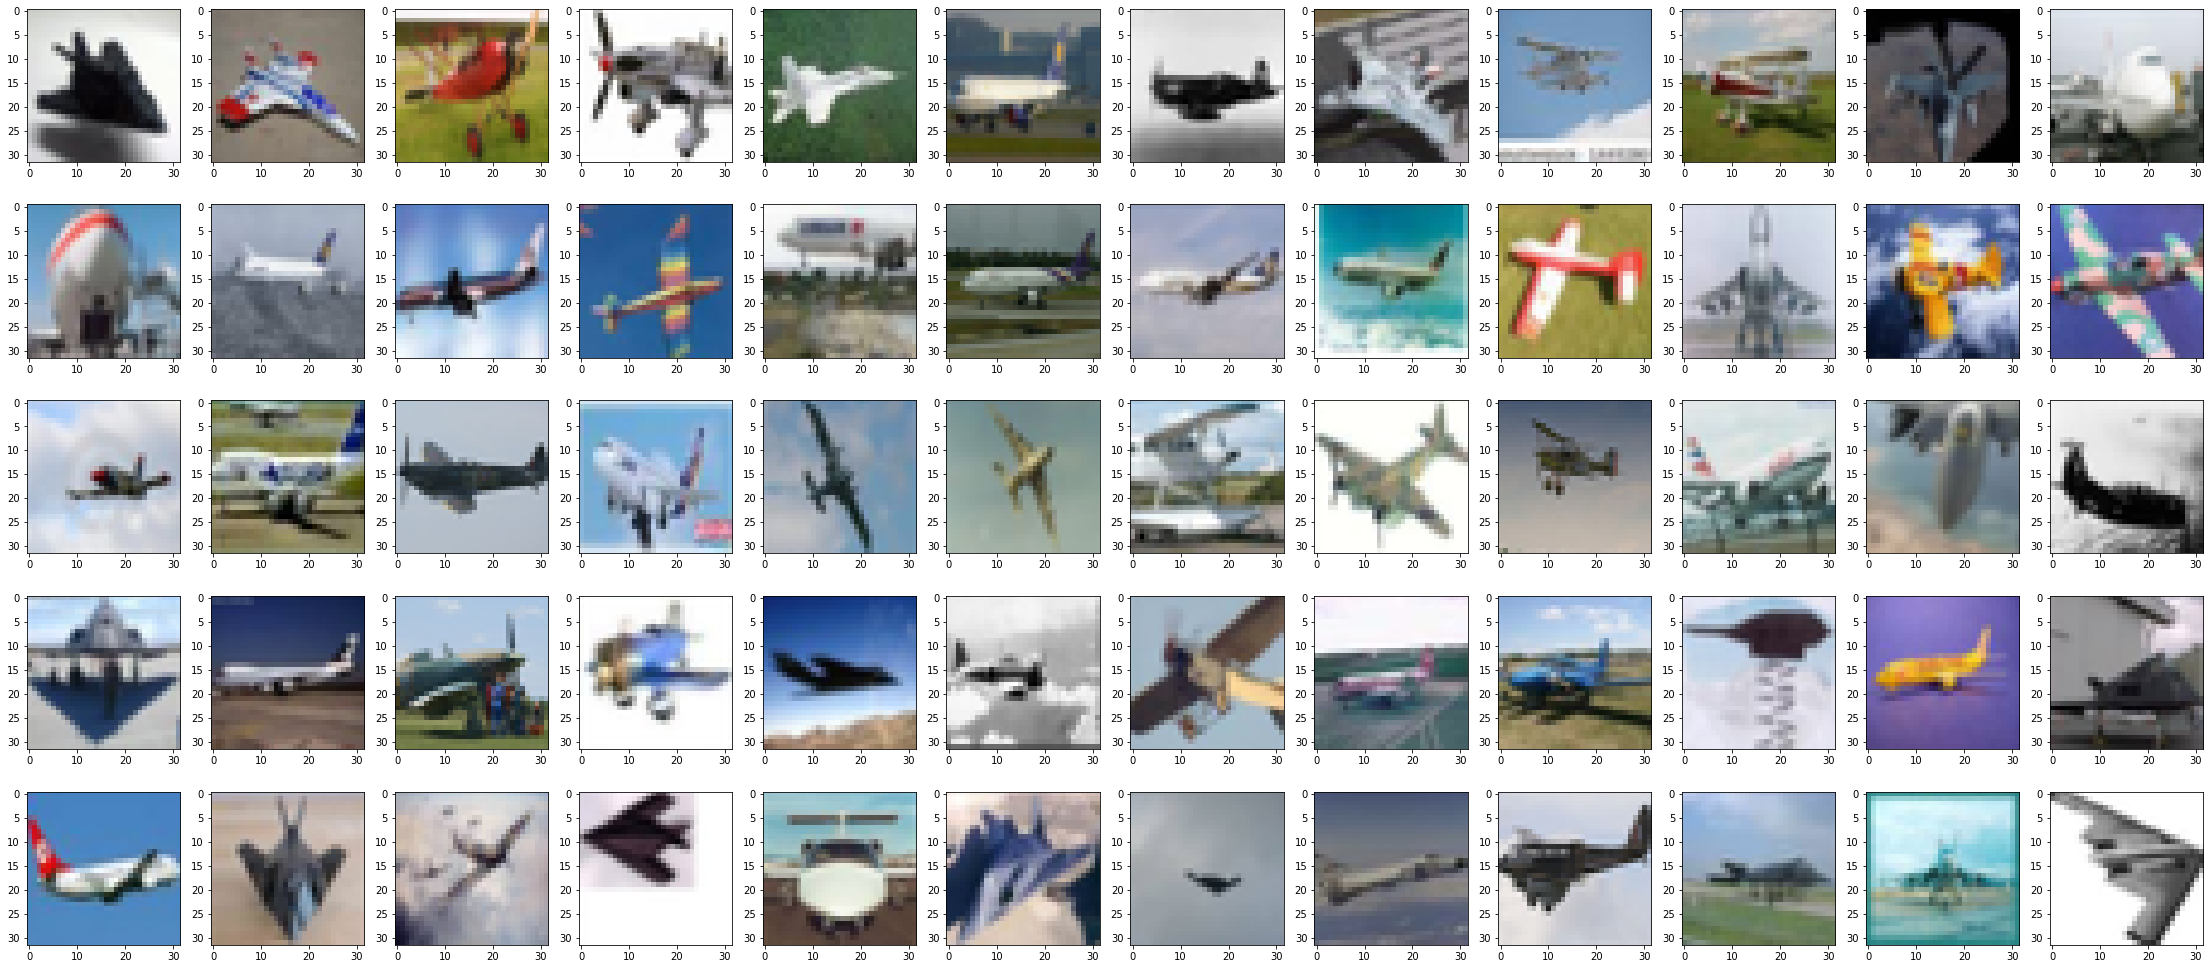

In [0]:
# TODO: DECIDE ON GITHUB OR DRIVE FOR HOSTING
# TODO: ADD CODE TO SAVE TRAINED MODEL
if(DATASET_CHOICE == 0):
  from google.colab import drive, files
  drive.mount("/content/gdrive", force_remount=True)
  !unzip -uq "/content/gdrive/My Drive/Dissertation/Data/SymbolSet/SymbolSet.zip" -d "/content/gdrive/My Drive/Dissertation/Data/SymbolSet/" 
  base_dir = "/content/gdrive/My Drive/Dissertation/Data/SymbolSet/Symbol Set"

  images = []
  for image in io.imread_collection(base_dir + "/*.jpg"): 
    image = np.array(resize(image, (128, 128)))
    if(image.shape == (128, 128, 3)):
      images.append(image)
  train_images = np.array(images[1:-1:2])
  test_images = np.array(images[0:-2:2])

  output_count = 9
  index_offset = 0

  print(train_images.shape)

  indexes = np.array([np.arange(5,8)])
  indexes = np.append(indexes, np.arange(8,11))
  indexes = np.append(indexes, np.arange(20,23))
  output_images = np.array(images)[indexes]
  fig = plt.figure(figsize=(39, 21))
  for i in range(output_count):
    ax = fig.add_subplot(1,output_count,i+1)
    plt.imshow(output_images[i])

  train_yuv  = tf.image.rgb_to_yuv(train_images)
  train_y = (train_images[:,:,:,0] + train_images[:,:,:,1] + train_images[:,:,:,2]) / 3
  train_y = tf.expand_dims(train_y[:,:,:], 3)
  train_uv = train_yuv[:,:,:,1:]

  test_yuv = tf.image.rgb_to_yuv(test_images)
  test_y = (test_images[:,:,:,0] + test_images[:,:,:,1] + test_images[:,:,:,2]) / 3
  test_y = tf.expand_dims(test_y[:,:,:], 3)
  test_uv = test_yuv[:,:,:,1:]

elif(DATASET_CHOICE == 1):
  (train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
  train_images = train_images / 255.0
  test_images = test_images / 255.0

  if(CIFAR10_CLASS is not None):
    class_train_indices = np.argwhere(train_labels == CIFAR10_CLASS)
    train_images = train_images[class_train_indices[:,0]]
    train_labels = train_labels[class_train_indices[:,0]]
    class_test_indices = np.argwhere(test_labels == CIFAR10_CLASS)
    test_images = test_images[class_test_indices[:,0]]
    test_labels = test_labels[class_test_indices[:,0]]

  image_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
  fig = plt.figure(figsize=(39, 21))
  count = 0
  for i in range(5):
    for j in range(12):
      ax = fig.add_subplot(6,12,count+1)
      if(CIFAR10_CLASS is None):
        plt.title(image_labels[int(train_labels[count])])
      plt.imshow(train_images[count])
      count += 1

  output_count = 12
  index_offset = 20

  train_yuv  = tf.image.rgb_to_yuv(train_images)
  train_y = tf.expand_dims(train_yuv[:,:,:,0], 3)
  train_uv = train_yuv[:,:,:,1:]

  test_yuv = tf.image.rgb_to_yuv(test_images)
  test_y = tf.expand_dims(test_yuv[:,:,:,0], 3)
  test_uv = test_yuv[:,:,:,1:]

elif(DATASET_CHOICE == 2):
  !git clone https://github.com/2014mchidamb/DeepColorization/

  images = train_images = test_images = []
  for image in io.imread_collection('DeepColorization/face_images/*.jpg'): 
    images.append(resize(image, (128, 128)))
    
  train_images = np.array(images)[0:-1:2,:,:,:]
  test_images = np.array(images)[1::2,:,:,:]

  index_offset = 20
  output_count = 12
  fig = plt.figure(figsize=(39, 21))
  count = 0
  for i in range(5):
    for j in range(12):
      ax = fig.add_subplot(6,12,count+1)
      plt.imshow(train_images[30+count])
      count += 1

  train_yuv  = tf.image.rgb_to_yuv(train_images)
  train_y = tf.expand_dims(train_yuv[:,:,:,0], 3)
  train_uv = train_yuv[:,:,:,1:]

  test_yuv = tf.image.rgb_to_yuv(test_images)
  test_y = tf.expand_dims(test_yuv[:,:,:,0], 3)
  test_uv = test_yuv[:,:,:,1:]

elif(DATASET_CHOICE == 3):
  from google.colab import drive, files
  drive.mount("/content/gdrive", force_remount=True)
  base_dir = "/content/gdrive/My Drive/Dissertation/Data/imagenette2-160/"

  categories = {"dog":"n02102040", "paraglider":"n03888257", "golfball":"n03445777", "church":"n03028079", "fish":"n01440764"}
  print("Loading and resizing training and testing images, this may take a few minutes.")
  images = []
  for image in io.imread_collection(base_dir + "train/" + categories[IMAGENETTE_CATEGORY] + "/*.JPEG"): 
    image = np.array(resize(image, (128, 128)))
    if(image.shape == (128, 128, 3)):
      images.append(image)
  train_images = np.array(images)
  images = []
  for image in io.imread_collection(base_dir + "val/" + categories[IMAGENETTE_CATEGORY] + "/*.JPEG"): 
    image = np.array(resize(image, (128, 128)))
    if(image.shape == (128, 128, 3)):
      images.append(image)
  test_images = np.array(images)

  fig = plt.figure(figsize=(39, 21))
  count = 0
  for i in range(5):
    for j in range(12):
      ax = fig.add_subplot(6,12,count+1)
      ax.axes.get_xaxis().set_visible(False)
      ax.axes.get_yaxis().set_visible(False)  
      plt.imshow(train_images[30+count])
      count += 1

  index_offset = 0
  output_count = 12

  train_yuv  = tf.image.rgb_to_yuv(train_images)
  train_y = tf.expand_dims(train_yuv[:,:,:,0], 3)
  train_uv = train_yuv[:,:,:,1:]

  test_yuv = tf.image.rgb_to_yuv(test_images)
  test_y = tf.expand_dims(test_yuv[:,:,:,0], 3)
  test_uv = test_yuv[:,:,:,1:]

# Create the Colourisation GAN

In [0]:
class GAN():
    def __init__(self):
        optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generated imgs
        y_image = layers.Input(shape=(32, 32, 1))
        uv_image = self.generator(y_image)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        validity = self.discriminator(uv_image)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity
        self.combined = models.Model(y_image, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

        self.gen_loss_history = []
        self.disc_loss_history = []
        self.disc_acc_history = []

    def build_generator(self):

        model = models.Sequential()

        # No dropout good
        model.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=(32, 32, 1)))
        # model.add(layers.LeakyReLU(alpha=0.2))
        model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
        # model.add(layers.LeakyReLU(alpha=0.2))
        # model.add(layers.Dropout(0.2))
        model.add(layers.BatchNormalization(momentum=0.8))
        model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
        # model.add(layers.LeakyReLU(alpha=0.2))
        # model.add(layers.Dropout(0.2))
        model.add(layers.BatchNormalization(momentum=0.8))
        model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
        # model.add(layers.LeakyReLU(alpha=0.2))
        model.add(layers.UpSampling2D((2, 2)))
        # model.add(layers.Dropout(0.2))
        model.add(layers.BatchNormalization(momentum=0.8))
        model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
        # model.add(layers.LeakyReLU(alpha=0.2))
        model.add(layers.UpSampling2D((2, 2)))
        model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
        # model.add(layers.LeakyReLU(alpha=0.2))
        # model.add(layers.Dropout(0.2))
        model.add(layers.BatchNormalization(momentum=0.8))
        model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
        # model.add(layers.LeakyReLU(alpha=0.2))
        model.add(layers.UpSampling2D((2, 2)))
        model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))

        # model.add(Dense(256, input_shape=(32, 32, 1)))
        # model.add(LeakyReLU(alpha=0.2))
        # model.add(BatchNormalization(momentum=0.8))
        # model.add(Dense(512))
        # model.add(LeakyReLU(alpha=0.2))
        # model.add(BatchNormalization(momentum=0.8))
        # model.add(Dense(1024))
        # model.add(LeakyReLU(alpha=0.2))
        # model.add(BatchNormalization(momentum=0.8))
        # model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        # model.add(Reshape(self.img_shape))

        model.summary()

        y_image = layers.Input(shape=(32, 32, 1))
        uv_image = model(y_image)

        return models.Model(y_image, uv_image)

    def build_discriminator(self):

        model = models.Sequential()

        # No dropout good
        # Batch normalisation really bad
        model.add(layers.Conv2D(16, (3,3), activation='relu', padding='same', input_shape=[32, 32, 2]))
        model.add(layers.Conv2D(16, (3,3), activation='relu', strides=(2,2), padding='same'))
        model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
        model.add(layers.Conv2D(32, (3,3), activation='relu', strides=(2,2), padding='same'))
        model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
        model.add(layers.Conv2D(128, (3,3), activation='relu', strides=(2,2), padding='same'))
        model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same'))
        model.add(layers.Flatten())
        model.add(layers.Dense(1, activation='sigmoid'))

        # model.add(Flatten(input_shape=img_shape))
        # model.add(Dense(512))
        # model.add(LeakyReLU(alpha=0.2))
        # model.add(Dense(256))
        # model.add(LeakyReLU(alpha=0.2))
        # model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = layers.Input(shape=(32, 32, 2))
        validity = model(img)

        return models.Model(img, validity)

    def train(self, epochs, y_images, uv_images, save_interval=50):
        self.gen_loss_history = []
        self.disc_loss_history = []
        self.disc_acc_history = []

        time_total = 0

        datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

        for epoch in range(1, epochs+1):
            start = time.time()
            batches = 0
            for x_batch, y_batch in datagen.flow(y_images, uv_images, batch_size=len(y_images)):
              # ---------------------
              #  Train Discriminator
              # ---------------------

              # Generate a batch of new images
              gen_imgs = self.generator.predict(x_batch)

              # Train the discriminator
              d_loss_real = self.discriminator.train_on_batch(y_batch, np.ones((y_batch.shape[0], 1)))
              d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((gen_imgs.shape[0], 1)))
              d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

              # ---------------------
              #  Train Generator
              # ---------------------

              # The generator wants the discriminator to label the generated samples
              # as valid (ones)
              valid_y = np.array([1] * gen_imgs.shape[0])

              # Train the generator
              g_loss = self.combined.train_on_batch(x_batch, valid_y)

              batches += 1
              if batches >= len(y_images) / BATCH_SIZE:
                  # we need to break the loop by hand because
                  # the generator loops indefinitely
                  break

            # Output the progress
            time_total += time.time()-start
            print("Epoch %d/%d - Time %fs - Estimated time left %ds - Discriminator loss: %f, acc.: %.2f%% - Generator loss: %f" % (epoch, epochs, time.time()-start, (time_total/epoch)*(epochs-epoch), d_loss[0], 100*d_loss[1], g_loss))
            self.gen_loss_history.append(g_loss)
            self.disc_loss_history.append(d_loss[0])
            self.disc_acc_history.append(100*d_loss[1])

    def generate_uv_images(self, y_images):
      return self.generator.predict(y_images)

    def get_training_metrics(self):
      return self.gen_loss_history, self.disc_loss_history, self.disc_acc_history



gan = GAN()
gan.train(TRAINING_EPOCHS, train_y, train_uv)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_158 (Conv2D)          (None, 32, 32, 16)        304       
_________________________________________________________________
conv2d_159 (Conv2D)          (None, 16, 16, 16)        2320      
_________________________________________________________________
conv2d_160 (Conv2D)          (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_161 (Conv2D)          (None, 8, 8, 32)          9248      
_________________________________________________________________
conv2d_162 (Conv2D)          (None, 8, 8, 64)          18496     
_________________________________________________________________
conv2d_163 (Conv2D)          (None, 4, 4, 128)         73856     
_________________________________________________________________
conv2d_164 (Conv2D)          (None, 4, 4, 256)       

# Diagnostic Learning Curve

In [0]:
gen_loss_history, disc_loss_history, disc_acc_history = gan.get_training_metrics()

fig = plt.figure(figsize=(38, 9))

fig.add_subplot(1,4,1)
plt.title("Fidelity")
plt.plot(gen_loss_history, label="Generator Loss")
plt.plot(disc_loss_history, label="Discriminator Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("Fidelity.png")
# files.download("Fidelity.png") 

fig.add_subplot(1,4,2)
plt.title("Smoothed")
plt.plot(gaussian_filter1d(gen_loss_history, sigma=2), label="Generator Loss")
plt.plot(gaussian_filter1d(disc_loss_history, sigma=2), label="Discriminator Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("Smooted.png")
# files.download("Smooted.png") 

# Training Results

In [0]:
output = gan.generate_uv_images(train_y)
result = np.zeros((train_y.shape[0], 32, 32, 3))
result[:,:,:,0] = train_y[:,:,:,0]
result[:,:,:,1:] = output

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Original")
  plt.imshow(train_images[i+index_offset])

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(result[i+index_offset]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U original")
  plt.imshow(train_yuv[i+index_offset,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U output")
  plt.imshow(result[i+index_offset,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V original")
  plt.imshow(train_yuv[i+index_offset,:,:,2])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V output")
  plt.imshow(result[i+index_offset,:,:,2])

# Testing Results

In [0]:
output = gan.generate_uv_images(test_y)
result = np.zeros((test_yuv.shape[0], 32, 32, 3))
result[:,:,:,0] = test_y[:,:,:,0]
result[:,:,:,1:] = output
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Original")
  plt.imshow(test_images[i+index_offset])

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(result[i+index_offset]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U original")
  plt.imshow(test_yuv[i+index_offset,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U output")
  plt.imshow(result[i+index_offset,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V original")
  plt.imshow(test_yuv[i+index_offset,:,:,2])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V output")
  plt.imshow(result[i+index_offset,:,:,2])